In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import mlxtend.plotting
import matplotlib.pyplot as plot
import os

In [2]:
DATASET_PATH = 'Samples' # the dataset file or root folder path.

# Image Parameters
N_CLASSES = 2 # CHANGE HERE, total number of classes
IMG_H_ACT = 1800 # Actual height of the image
IMG_W_ACT = 1200 # Actual width of the image
IMG_HEIGHT = 64 # CHANGE HERE, the image height to be resized to
IMG_WIDTH = 64 # CHANGE HERE, the image width to be resized to
CHANNELS = 3 # The 3 color channels, change to 1 if grayscale

def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image /= 255.0
    return image, label

def read_images(dataset_path):
    imagepaths, labels = list(), list()
    label = 0
    classes = sorted(os.walk(dataset_path).__next__()[1])
    # List each sub-directory (the classes)
    for c in classes:
        c_dir = os.path.join(dataset_path, c)
        walk = os.walk(c_dir).__next__()
        # Add each image to the training set
        for sample in walk[2]:
            if sample.endswith('.jpg') or sample.endswith('.jpeg'):
                imagepaths.append(os.path.join(c_dir, sample))
                labels.append(label)
        label += 1
        
    imagepaths = tf.convert_to_tensor(imagepaths, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    
    # Build a TF Queue, shuffle data
    ds_files_labels = tf.data.Dataset.from_tensor_slices((imagepaths, labels))
    ds = ds_files_labels.map(load_and_preprocess)
    return ds

In [3]:
ds = read_images(DATASET_PATH)
ds.batch(20)

Metal device set to: Apple M1


<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
model = tf.keras.models.load_model('fm_faces.h5')

In [5]:
pred_logits = model.predict(ds.batch(20))
prob = tf.sigmoid(pred_logits)
prob = prob.numpy().flatten()*100

2023-07-03 22:06:29.412582: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 908ms/step


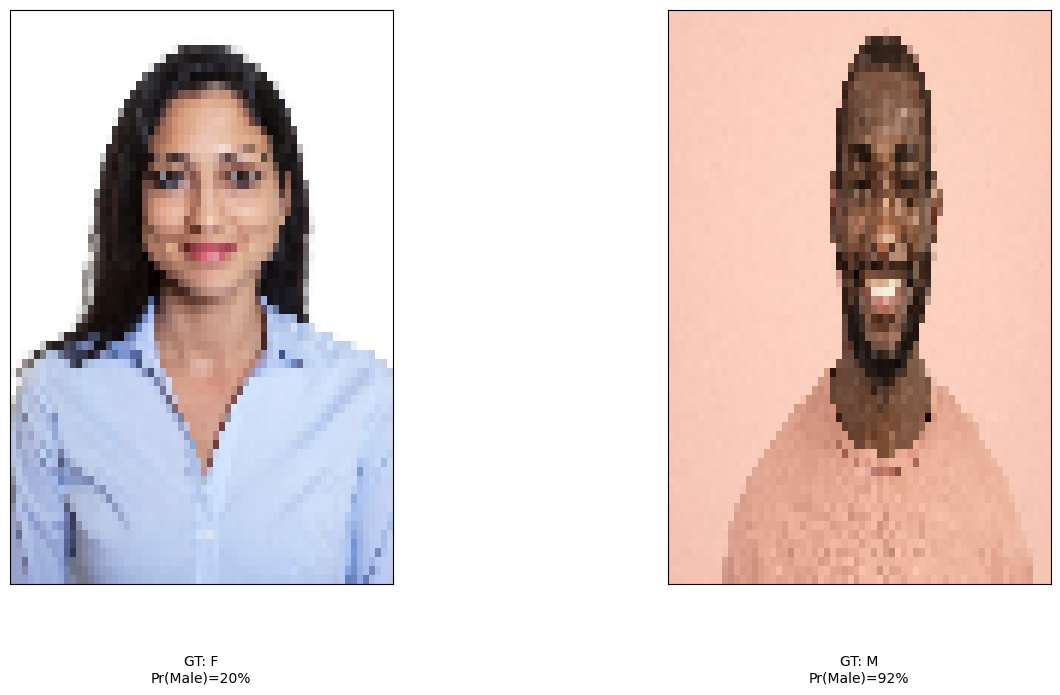

In [6]:
fig = plot.figure(figsize=(15, 7))
aspect = IMG_H_ACT/IMG_W_ACT

for j, example in enumerate(ds):
    ax = fig.add_subplot(1, 2, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0], aspect=aspect)
    if example[1].numpy() == 1:
        label = 'M'
    else:
        label = 'F'
    ax.text(0.5, -0.15, 'GT: {:s}\nPr(Male)={:.0f}%' ''.format(label, prob[j]), size=10, horizontalalignment='center',
           verticalalignment='center', transform=ax.transAxes)
plot.tight_layout()
plot.show()